In [5]:
import os
import cv2
import time
import imageio
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
img_path = '/home/joaolevi/projects/pdi/images/valhala2.webp'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams["figure.dpi"] = 100

In [7]:
ref_images = ["imageio:coffee.png", "imageio:page.png", "imageio:immunohistochemistry.png", "imageio:horse.png"] 

In [8]:
images_orig = [cv2.resize(imageio.imread(im), (400,400)) for im in ref_images] 
# interpolation methods to compare
methods=[("area", cv2.INTER_AREA), 
         ("nearest", cv2.INTER_NEAREST), 
         ("linear", cv2.INTER_LINEAR), 
         ("cubic", cv2.INTER_CUBIC), 
         ("lanczos4", cv2.INTER_LANCZOS4)]

/tmp/ipykernel_8131/1562047281.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_orig = [cv2.resize(imageio.imread(im), (400,400)) for im in ref_images]


Imageio: 'coffee.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/coffee.png (441 kB)
Downloading: 8192/451102 bytes (1.8106496/451102 bytes (23.6%451102/451102 bytes (100.0%)
  Done
File saved as /home/joaolevi/.imageio/images/coffee.png.
Imageio: 'page.png' was not found on your computer; downloading it now.


/tmp/ipykernel_8131/1562047281.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_orig = [cv2.resize(imageio.imread(im), (400,400)) for im in ref_images]


Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/page.png (43 kB)
Downloading: 8192/44122 bytes (18.644122/44122 bytes (100.0%)
  Done
File saved as /home/joaolevi/.imageio/images/page.png.
Imageio: 'immunohistochemistry.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/immunohistochemistry.png (459 kB)
Downloading: 8192/470201 bytes (1.7139264/470201 bytes (29.6%470201/470201 bytes (100.0%)
  Done
File saved as /home/joaolevi/.imageio/images/immunohistochemistry.png.
Imageio: 'horse.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/horse.png (14 kB)
Downloading: 8192/14540 bytes (56.314540/14540 bytes (100.0%)
  Done
File saved as /home/joaolevi/.imageio/images/horse.png.


In [13]:
def display(images, titles=['']):
    if isinstance(images[0], list):
        c = len(images[0])
        r = len(images)
        images = list(itertools.chain(*images))
    else:
        c = len(images)
        r = 1
    plt.figure(figsize=(2*c, 2*r))
    gs1 = gridspec.GridSpec(r, c, wspace=0, hspace=0)
    for i in range(r*c):
        im = images[i]
        title = titles[i%c]
        plt.subplot(gs1[i])
        plt.imshow(im, cmap='gray', interpolation='none')
        plt.axis('off')
        if i < c:
            plt.title(title)
    plt.tight_layout()

### Upsampling comparison

Take 50x50 
 image and rescale it to 400x400
 pixels. For ease of comparison, the original and the rescaled are shown at the same size so the algorithm image quality can be compared. For updampling, area & nearest algorithms create jagged edges while the linear makes smoother edges. The cubic and Lanczos make the sharpest edges.

In [14]:
images_small = [cv2.resize(im, (50,50), interpolation=cv2.INTER_AREA) for im in images_orig]
image_set = [[cv2.resize(im, (400,400), interpolation=m[1]) for m in methods] for im in images_small]
image_set = [[ima,]+imb for ima, imb in zip(images_small, image_set)]
names = ["original 50x50",] + [m[0]+" 400x400" for m in methods]

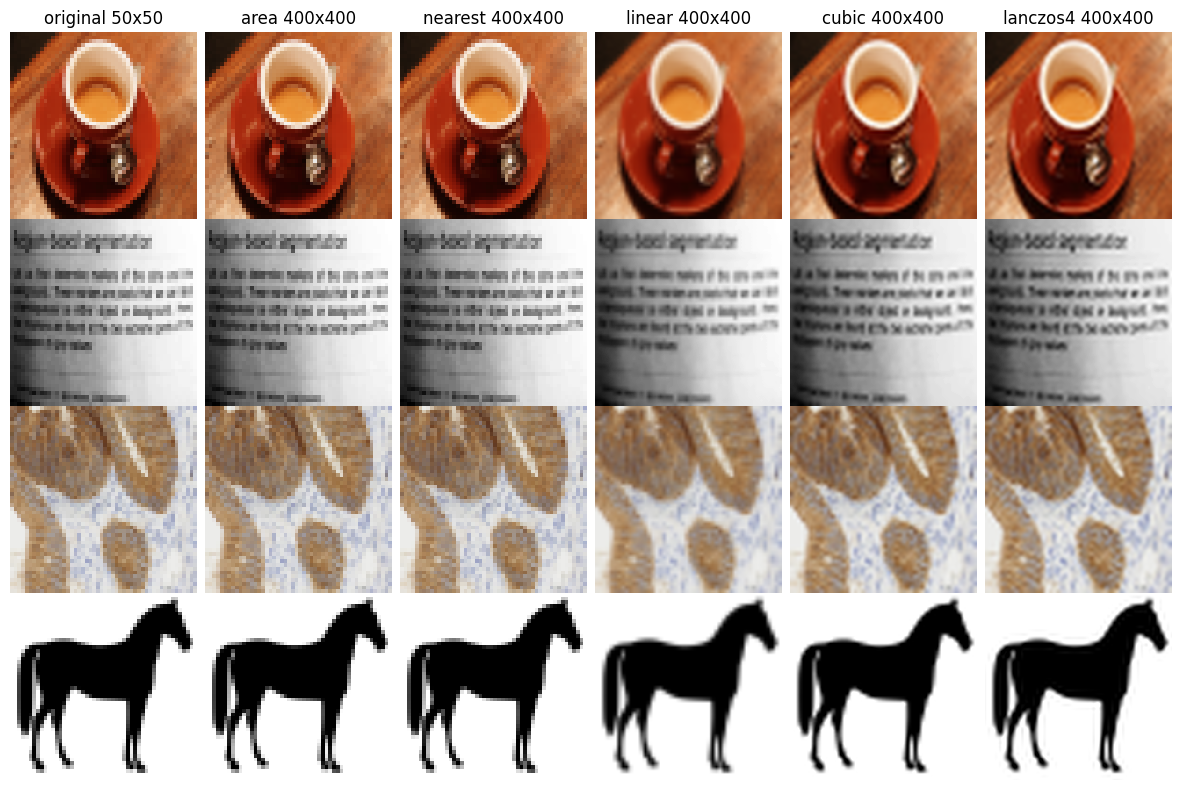

In [15]:
display(image_set, names)
# plt.savefig("opencv_interpolation_upsample.jpg", dpi=75)

### Downsampling comparison
Take a 400x400 
 image and rescale it to 50x50 
 pixels.

For ease of comparison, the original and the rescaled are shown at the same size so the algorithm image quality can be compared.

For downsampling, the area algorithm avoids aliasing while the other algorithms are not really designed for decimation and aliasing results.

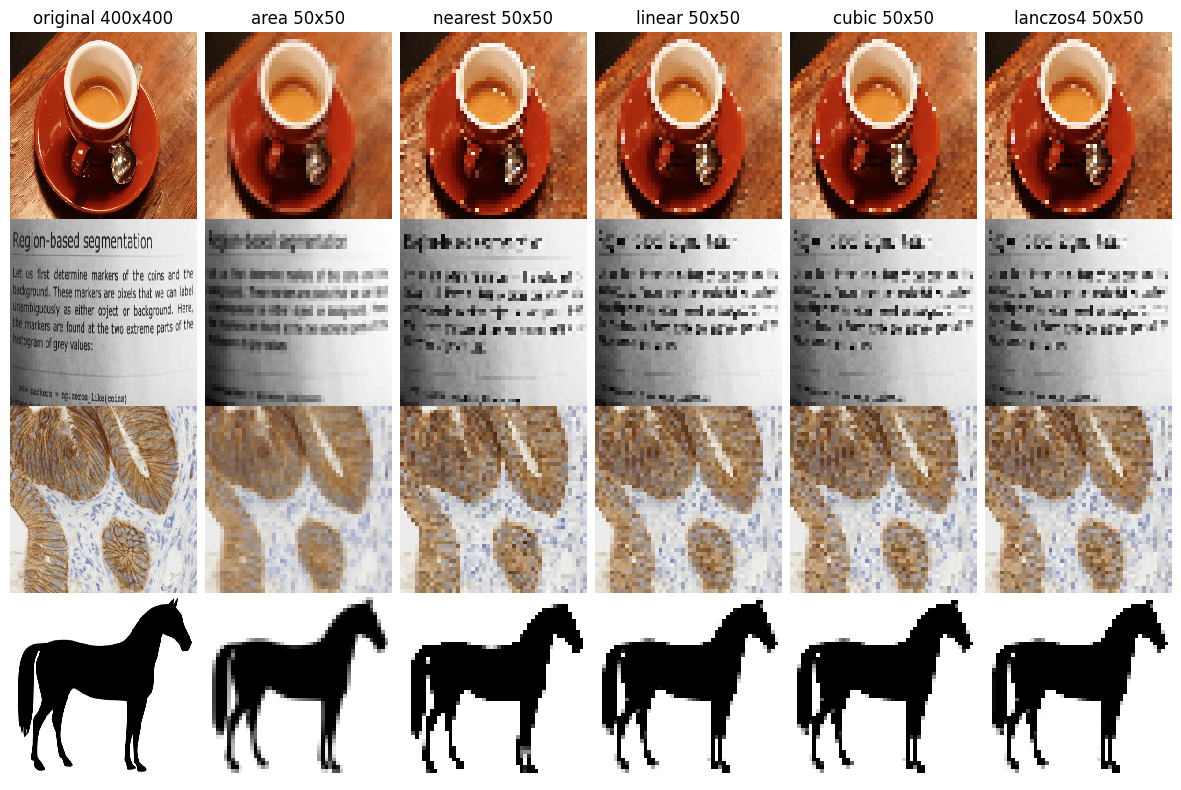

In [16]:
image_set = [[cv2.resize(im, (50,50), interpolation=m[1]) for m in methods] for im in images_orig]
image_set = [[ima,]+imb for ima, imb in zip(images_orig, image_set)]
names = ["original 400x400",] + [m[0]+" 50x50" for m in methods]
display(image_set, names)

### Speed comparison
The below plot shows that the linear algorithm is very well optimized and gives nearly the same speed as the nearest algorithm. The more complex algorithms have much more overhead.

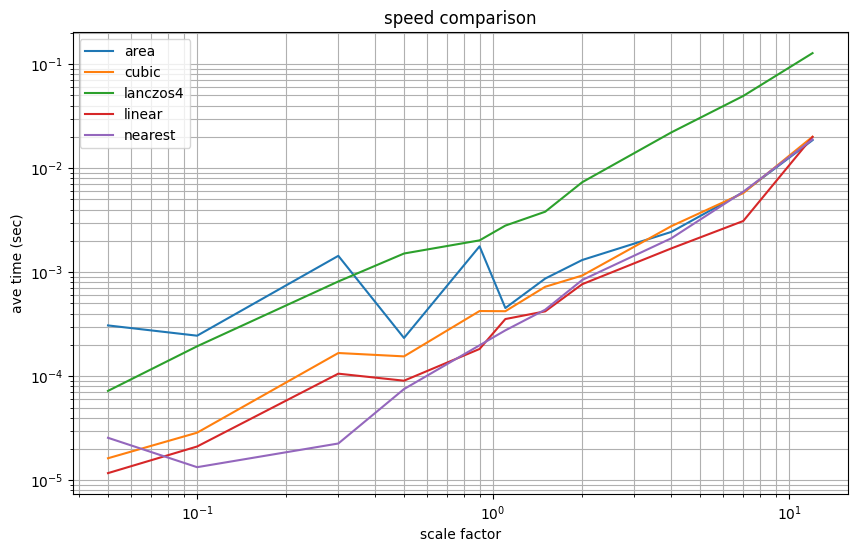

In [18]:
n=20
data = []
scale_factors = [0.05, 0.1, 0.3, 0.5, 0.9, 1.1, 1.5, 2, 4, 7, 12]
for m in methods:
    for sf in scale_factors:
        di = []
        for i in range(n):
            t0 = time.time()
            cv2.resize(images_orig[0], (0,0), fx=sf, fy=sf, interpolation=m[1])
            dt = (time.time()-t0)
            di.append(dt)
        dt = np.mean(di)
        err = 2*np.std(di)
        data.append(dict(time=dt, method=m[0], err=err, scale=sf))
data = pd.DataFrame(data)

g = data.groupby("method")
plt.figure(figsize(10,6))
for n, gi in g:
    plt.plot(gi["scale"], gi["time"], label=n)
plt.loglog()
plt.legend()
plt.xlabel("scale factor")
plt.ylabel("ave time (sec)")
plt.title("speed comparison")
plt.grid(which="both")
# plt.savefig("opencv_interpolation_speed_plot.jpg", dpi=150)